1.1 Synonym Sets

In [1]:
import nltk
from nltk.corpus import wordnet as wn

# Download WordNet data (if not already downloaded)
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amirmohammad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Get all synsets for the lemma "orange"
orange_synsets = wn.synsets('orange')

# Display the results
for syn in orange_synsets:
    lemmas = [lemma.name() for lemma in syn.lemmas()]
    supersense = syn.lexname()
    pos = syn.pos()
    definition = syn.definition()
    
    print(f"• {{{', '.join(lemmas)}}} — {supersense} ({pos}): {definition}")


• {orange} — noun.food (n): round yellow to orange fruit of any of several citrus trees
• {orange, orangeness} — noun.attribute (n): orange color or pigment; any of a range of colors between red and yellow
• {orange, orange_tree} — noun.plant (n): any citrus tree bearing oranges
• {orange} — noun.substance (n): any pigment producing the orange color
• {Orange, Orange_River} — noun.object (n): a river in South Africa that flows generally westward to the Atlantic Ocean
• {orange, orangish} — adj.all (s): of the color between red and yellow; similar to the color of a ripe orange


1.2 Sense Relations

In [3]:
# Identify the synset for orange as a fruit
orange_fruit = wn.synset('orange.n.01')  # 'orange' as a citrus fruit
print(f"Starting synset: {orange_fruit.lemmas()[0].name()} - {orange_fruit.definition()}")


Starting synset: orange - round yellow to orange fruit of any of several citrus trees


In [4]:
# Collect synsets along the hypernym path
hypernym_path = []
current = orange_fruit

while True:
    hypernym_path.append(current)
    hypers = current.hypernyms()
    if not hypers:
        break
    current = hypers[0]  # follow the first hypernym (can be multiple)

for syn in hypernym_path:
    print(f"{syn.name()}: {', '.join(lemma.name() for lemma in syn.lemmas())} — {syn.definition()}")


orange.n.01: orange — round yellow to orange fruit of any of several citrus trees
citrus.n.01: citrus, citrus_fruit, citrous_fruit — any of numerous fruits of the genus Citrus having thick rind and juicy pulp; grown in warm regions
edible_fruit.n.01: edible_fruit — edible reproductive body of a seed plant especially one having sweet flesh
fruit.n.01: fruit — the ripened reproductive body of a seed plant
reproductive_structure.n.01: reproductive_structure — the parts of a plant involved in its reproduction
plant_organ.n.01: plant_organ — a functional and structural unit of a plant or fungus
plant_part.n.01: plant_part, plant_structure — any part of a plant or fungus
natural_object.n.01: natural_object — an object occurring naturally; not made by man
whole.n.02: whole, unit — an assemblage of parts that is regarded as a single entity
object.n.01: object, physical_object — a tangible and visible entity; an entity that can cast a shadow
physical_entity.n.01: physical_entity — an entity tha

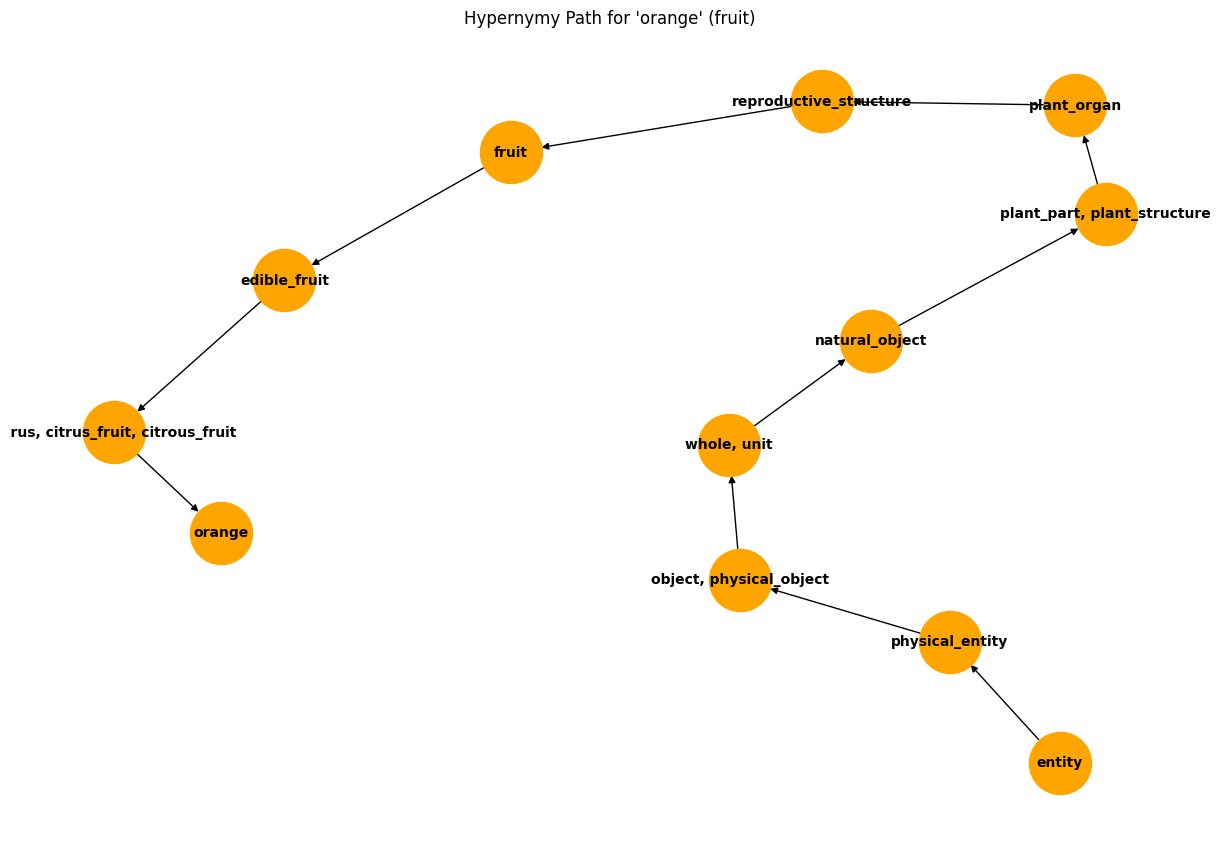

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Build the directed graph
G = nx.DiGraph()

for i in range(len(hypernym_path) - 1):
    child = ', '.join(hypernym_path[i].lemma_names())
    parent = ', '.join(hypernym_path[i+1].lemma_names())
    G.add_edge(parent, child)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5) # k is the distance between nodes
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=2000, font_size=10, font_weight='bold', arrows=True)
plt.title("Hypernymy Path for 'orange' (fruit)")
plt.show()


In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amirmohammad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amirmohammad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

2.1 Knowledge-Based Approach

In [83]:
from itertools import product
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text, do_lower=True, do_stop=True, do_stem=True):
    toks = tokenize(text)
    if do_lower:
        toks = [t.lower() for t in toks]
    if do_stop:
        toks = [t for t in toks if t not in STOP_WORDS]
    if do_stem:
        toks = [STEMMER.stem(t) for t in toks]
    return toks

def max_wupalmer_similarity(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    
    max_sim = 0
    for s1, s2 in product(synsets1, synsets2):
        sim = wn.wup_similarity(s1, s2)
        if sim and sim > max_sim:
            max_sim = sim
    return max_sim


In [84]:
def text_relatedness(text1, text2):
    Ta = preprocess(text1)
    Tb = preprocess(text2)
    
    a = len(Ta)
    b = len(Tb)
    
    shared_terms = set(Ta) & set(Tb)
    ω = len(shared_terms)

    Ta_unshared = list(set(Ta) - shared_terms)
    Tb_unshared = list(set(Tb) - shared_terms)
    
    # Compute pairwise similarities
    pair_sims = []
    for w1 in Ta_unshared:
        for w2 in Tb_unshared:
            sim = max_wupalmer_similarity(w1, w2)
            if sim:
                pair_sims.append(((w1, w2), sim))
    
    # Sort by similarity descending and select best disjoint pairs
    pair_sims.sort(key=lambda x: x[1], reverse=True)
    
    used_Ta = set()
    used_Tb = set()
    ϕ = []

    for (w1, w2), sim in pair_sims:
        if w1 not in used_Ta and w2 not in used_Tb:
            ϕ.append(sim)
            used_Ta.add(w1)
            used_Tb.add(w2)
    
    total_sim = sum(ϕ)
    relatedness = (2 * a * b / (a + b)) * (ω + total_sim)
    
    return relatedness


2.2 Corpus-Based Approach

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1) disable all preprocessing/tokenizing
vectorizer = TfidfVectorizer(
    lowercase=False,
    preprocessor=lambda doc: doc,
    tokenizer=lambda tokens: tokens,
    token_pattern=None,
    
    
    sublinear_tf=True,    
    smooth_idf=True,      
    norm='l2'             # cosine similarity uses l2‑normalized vectors by default
)


3.1 Dataset
3.2 Data Preparation

In [21]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Compile your regex tokenizer once
TOKENIZER_RE = re.compile(r"(?u)\b\w\w+\b")

# Load resources
STOP_WORDS = set(stopwords.words('english'))
STEMMER    = PorterStemmer()

def tokenize(text):
    """
    Split `text` into tokens of at least two alphanumeric/underscore chars.
    """
    return TOKENIZER_RE.findall(text)

def preprocess(
    text,
    *,
    do_lower: bool = True,
    do_stop:  bool = True,
    do_stem:  bool = True
):
    """
    Tokenize and optionally lowercase, remove stop words, and stem.
    
    Returns:
        List[str] — processed tokens.
    """
    # 1) Tokenize raw text
    tokens = tokenize(text)
    
    # 2) Case folding
    if do_lower:
        tokens = [t.lower() for t in tokens]
    
    # 3) Stop‑word removal
    if do_stop:
        tokens = [t for t in tokens if t not in STOP_WORDS]
    
    # 4) Stemming
    if do_stem:
        tokens = [STEMMER.stem(t) for t in tokens]
    
    return tokens

# ── Example ──
if __name__ == "__main__":
    sample = "The quick brown foxes jumped over the lazy dog's back!"
    print("Raw tokens:      ", tokenize(sample))
    print("Lower + stop:    ", preprocess(sample, do_lower=True, do_stop=True, do_stem=False))
    print("Lower + stem:    ", preprocess(sample, do_lower=True, do_stop=False, do_stem=True))
    print("All steps on:    ", preprocess(sample, do_lower=True, do_stop=True, do_stem=True))


Raw tokens:       ['The', 'quick', 'brown', 'foxes', 'jumped', 'over', 'the', 'lazy', 'dog', 'back']
Lower + stop:     ['quick', 'brown', 'foxes', 'jumped', 'lazy', 'dog', 'back']
Lower + stem:     ['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog', 'back']
All steps on:     ['quick', 'brown', 'fox', 'jump', 'lazi', 'dog', 'back']


3.3 Corpus-Based Retrieval

In [ ]:
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ───────────
# 1. PREPROCESSING PIPELINE
# ───────────
TOKENIZER_RE = re.compile(r"(?u)\b\w\w+\b")
STOP_WORDS   = set(stopwords.words('english'))
STEMMER      = PorterStemmer()

def tokenize(text):
    return TOKENIZER_RE.findall(text)

def preprocess(text, do_lower=True, do_stop=True, do_stem=True):
    toks = tokenize(text)
    if do_lower:
        toks = [t.lower() for t in toks]
    if do_stop:
        toks = [t for t in toks if t not in STOP_WORDS]
    if do_stem:
        toks = [STEMMER.stem(t) for t in toks]
    return toks

# ───────────
# 2. LOAD DATA
# ───────────
# Load the mini dataset
docs_df   = pd.read_csv('mini/documents.csv')   # columns: document_id, content
qrys_df   = pd.read_csv('mini/queries.csv')     # columns: query_id, query
labels_df = pd.read_csv('mini/labels.csv')      # columns: query_id, document_id, is_relevant

# Preprocess all texts
# You can toggle the booleans here to experiment
DO_LOWER = True
DO_STOP  = True
DO_STEM  = True

docs_df['tokens'] = docs_df['content'].map(lambda t: preprocess(t, DO_LOWER, DO_STOP, DO_STEM))
qrys_df['tokens'] = qrys_df['query'].map(lambda t: preprocess(t, DO_LOWER, DO_STOP, DO_STEM))

# Represent each document/query as the space‑joined token string
docs_df['proc_text'] = docs_df['tokens'].map(lambda toks: ' '.join(toks))
qrys_df['proc_text'] = qrys_df['tokens'].map(lambda toks: ' '.join(toks))

# ───────────
# 3. TF‑IDF FIT ON FULL VOCAB
# ───────────
vectorizer = TfidfVectorizer(
    lowercase=False,           # already done
    tokenizer=lambda tokens: tokens,
    preprocessor=lambda doc: doc,
    token_pattern=None,        # type: ignore
    sublinear_tf=True,         
    smooth_idf=True,           
    norm='l2'
)

# Fit on both queries and documents for a unified IDF
all_texts = pd.concat([docs_df['proc_text'], qrys_df['proc_text']])
vectorizer.fit(all_texts)

# IDF values -> save or inspect
idf_df = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'idf':   vectorizer.idf_
})
print("Top 10 highest‑idf terms:\n", idf_df.sort_values('idf', ascending=False).head(10))

# ───────────
# 4. TRANSFORM TO TF‑IDF MATRICES
# ───────────
tfidf_docs = vectorizer.transform(docs_df['proc_text'])   # shape (n_docs, n_terms)
tfidf_qrys = vectorizer.transform(qrys_df['proc_text'])   # shape (n_qrys, n_terms)

# ───────────
# 5. COSINE SIMILARITY & RANKING
# ───────────
# Compute full similarity matrix (n_qrys × n_docs)
sim_matrix = cosine_similarity(tfidf_qrys, tfidf_docs)

# For each query, get sorted doc indices
ranked_docs_tfidf = {
    qid: list(docs_df['document_id'].iloc[np.argsort(-sim_matrix[i])].values)
    for i, qid in enumerate(qrys_df['query_id'])
}

# ───────────
# 6. EXTRACT TOP‑10 FOR QUERY 256
# ───────────
QID = 256
top10 = ranked_docs_tfidf[QID][:10]

# Lookup true labels
relevant_for_q = labels_df[labels_df['query_id'] == QID].set_index('document_id')['is_relevant']
top10_labels = [(doc, relevant_for_q.get(doc, 0)) for doc in top10]

print(f"Top 10 docs for query {QID} (document_id, true_label):")
for rank, (doc, lbl) in enumerate(top10_labels, 1):
    print(f"{rank:2d}. Doc {doc}  — relevant? {lbl}")


Top 10 highest‑idf terms:
    term       idf
58    ñ  8.938267
57    î  8.938267
44    ¾  8.938267
39    ³  8.938267
42    ¼  8.938267
62    ø  8.938267
55    ì  8.938267
54    ê  8.938267
38    ²  8.938267
45    à  8.938267
Top 10 docs for query 256 (document_id, true_label):
 1. Doc 582  — relevant? 0
 2. Doc 1976  — relevant? 0
 3. Doc 4283  — relevant? 0
 4. Doc 3415  — relevant? 0
 5. Doc 1446  — relevant? 0
 6. Doc 2138  — relevant? 1
 7. Doc 2139  — relevant? 0
 8. Doc 1803  — relevant? 0
 9. Doc 85  — relevant? 0
10. Doc 1204  — relevant? 0



### Preprocessing Grid-Search Results

| lower   | stop   | stem   |       MAP |       MRR |      Top@1 |     Top@5 |    Top@10 |     NDCG@1 |     NDCG@5 |   NDCG@10 |
|:--------|:-------|:-------|----------:|----------:|-----------:|----------:|----------:|-----------:|-----------:|----------:|
| True    | True   | True   | 0.0486891 | 0.0662418 | 0.0333333  | 0.0933333 | 0.125     | 0.0333333  | 0.0472908  | 0.0566759 |
| True    | True   | False  | 0.0472504 | 0.0628724 | 0.0316667  | 0.085     | 0.106667  | 0.0316667  | 0.045211   | 0.0526693 |
| True    | False  | True   | 0.0347604 | 0.0467728 | 0.02       | 0.07      | 0.0816667 | 0.02       | 0.0348081  | 0.0381968 |
| True    | False  | False  | 0.0334996 | 0.0433168 | 0.02       | 0.06      | 0.0816667 | 0.02       | 0.0316517  | 0.0382303 |
| False   | True   | True   | 0.0452165 | 0.0625751 | 0.0283333  | 0.09      | 0.12      | 0.0283333  | 0.0436403  | 0.0530687 |
| False   | True   | False  | 0.0184753 | 0.0226949 | 0.0

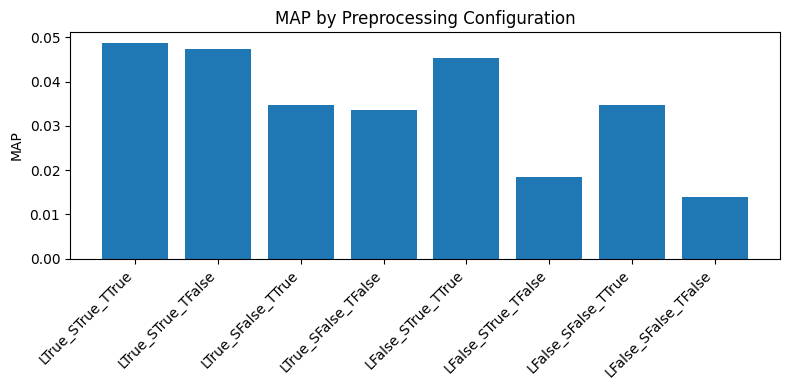


Best config (lower, stop, stem): (np.True_, np.True_, np.True_)

Top 10 docs for query 256 under best config:
 1. Doc 582 — relevant? 0
 2. Doc 1976 — relevant? 0
 3. Doc 4283 — relevant? 0
 4. Doc 3415 — relevant? 0
 5. Doc 1446 — relevant? 0
 6. Doc 2138 — relevant? 1
 7. Doc 2139 — relevant? 0
 8. Doc 1803 — relevant? 0
 9. Doc 85 — relevant? 0
10. Doc 1204 — relevant? 0

Query Text (QID=256):
The greenhouse effect is a result of

Top 10 Recommended Documents (with snippet):
 1. Doc ID: 582 | Relevant: 0 | Snippet: If one asks an expert for the rules he or she is using, one will, in effect, force the expert to regress to the level of a beginner and state the rule
 2. Doc ID: 1976 | Relevant: 0 | Snippet: Indestructible creatures in Magic: the Gathering cannot be destroyed by lethal damage or destruction effects, but they are put into the graveyard if i
 3. Doc ID: 4283 | Relevant: 0 | Snippet: We toss around references to different burger styles on this site all the time, but it oc

In [96]:
import re, itertools
import pandas as pd
import numpy as np
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ───────────
# 1. LOAD DATA
# ───────────
docs_df   = pd.read_csv('mini/documents.csv')   # document_id, content
qrys_df   = pd.read_csv('mini/queries.csv')     # query_id, query
labels_df = pd.read_csv('mini/labels.csv')      # query_id, document_id, is_relevant

# ───────────
# 2. PREPROCESSING SETUP
# ───────────
TOKENIZER_RE = re.compile(r"(?u)\b\w\w+\b")
STOP_WORDS   = set(stopwords.words('english'))
STEMMER      = PorterStemmer()

def tokenize(text):
    return TOKENIZER_RE.findall(text)

def preprocess(text, do_lower, do_stop, do_stem):
    toks = tokenize(text)
    if do_lower:
        toks = [t.lower() for t in toks]
    if do_stop:
        toks = [t for t in toks if t not in STOP_WORDS]
    if do_stem:
        toks = [STEMMER.stem(t) for t in toks]
    return toks

# ───────────
# 3. BUILD GROUND-TRUTH ONCE
# ───────────
ground_truth = defaultdict(set)
for _, row in labels_df.iterrows():
    if row['is_relevant'] == 1:
        ground_truth[row['query_id']].add(row['document_id'])

# ───────────
# 4. GRID SEARCH OVER PREPROCESSING CONFIGS
# ───────────
configs = list(itertools.product([True, False], [True, False], [True, False]))
results = []

for do_lower, do_stop, do_stem in configs:
    # 4.1 Preprocess texts
    docs_df['tokens'] = docs_df['content']\
        .map(lambda t: preprocess(t, do_lower, do_stop, do_stem))
    qrys_df['tokens'] = qrys_df['query']\
        .map(lambda t: preprocess(t, do_lower, do_stop, do_stem))
    docs_df['proc_text'] = docs_df['tokens'].map(lambda toks: ' '.join(toks))
    qrys_df['proc_text'] = qrys_df['tokens'].map(lambda toks: ' '.join(toks))

    # 4.2 TF–IDF vectorization (fit on docs+queries)
    vectorizer = TfidfVectorizer(
        lowercase=False,
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        sublinear_tf=True,
        smooth_idf=True,
        norm='l2'
    )
    all_texts = pd.concat([docs_df['proc_text'], qrys_df['proc_text']])
    vectorizer.fit(all_texts)
    tfidf_docs = vectorizer.transform(docs_df['proc_text'])
    tfidf_qrys = vectorizer.transform(qrys_df['proc_text'])

    # 4.3 Rank for every query
    sim = cosine_similarity(tfidf_qrys, tfidf_docs)
    predictions = {
        qid: list(docs_df['document_id'].iloc[np.argsort(-sim[i])].values)
        for i, qid in enumerate(qrys_df['query_id'])
    }

    # 4.4 Evaluate
    metrics = compute_metrics(predictions, ground_truth)
    results.append({
        'lower': do_lower,
        'stop':  do_stop,
        'stem':  do_stem,
        **metrics
    })

# ───────────
# 5. TABULATE GRID-SEARCH RESULTS
# ───────────
grid_df = pd.DataFrame(results)
cols = ['lower','stop','stem','MAP','MRR','Top@1','Top@5','Top@10',
        'NDCG@1','NDCG@5','NDCG@10']
grid_df = grid_df[cols]
print("\n### Preprocessing Grid-Search Results\n")
print(grid_df.to_markdown(index=False))

# ───────────
# 6. PLOT MAP ACROSS CONFIGS
# ───────────
plt.figure(figsize=(8,4))
plt.bar(range(len(grid_df)), grid_df['MAP'])
labels = [f"L{l}_S{st}_T{m}" 
          for l,st,m in zip(grid_df['lower'], grid_df['stop'], grid_df['stem'])]
plt.xticks(range(len(grid_df)), labels, rotation=45, ha='right')
plt.title("MAP by Preprocessing Configuration")
plt.ylabel("MAP")
plt.tight_layout()
plt.show()

# ───────────
# 7. EXTRACT BEST CONFIG (BY MAP)
# ───────────
best = grid_df.loc[grid_df['MAP'].idxmax()]
best_config = (best['lower'], best['stop'], best['stem'])
print("\nBest config (lower, stop, stem):", best_config)

# ───────────
# 8. RE-RUN BEST CONFIG AND SHOW TOP-10 FOR QID=256
# ───────────
do_lower, do_stop, do_stem = best_config

# Re-preprocess
docs_df['tokens'] = docs_df['content'].map(lambda t: preprocess(t, do_lower, do_stop, do_stem))
qrys_df['tokens'] = qrys_df['query'].map(lambda t: preprocess(t, do_lower, do_stop, do_stem))
docs_df['proc_text'] = docs_df['tokens'].map(lambda toks: ' '.join(toks))
qrys_df['proc_text'] = qrys_df['tokens'].map(lambda toks: ' '.join(toks))

# Re-vectorize & rank
vectorizer.fit(pd.concat([docs_df['proc_text'], qrys_df['proc_text']]))
tfidf_docs = vectorizer.transform(docs_df['proc_text'])
tfidf_qrys = vectorizer.transform(qrys_df['proc_text'])
sim = cosine_similarity(tfidf_qrys, tfidf_docs)

QID = 256
ranked_256 = list(
    docs_df['document_id']
           .iloc[np.argsort(-sim[qrys_df[qrys_df['query_id']==QID].index[0]])]
           .values
)[:10]

# True labels
truth256 = labels_df[labels_df['query_id']==QID]\
           .set_index('document_id')['is_relevant']
print(f"\nTop 10 docs for query {QID} under best config:")
for i, doc in enumerate(ranked_256, 1):
    print(f"{i:2d}. Doc {doc} — relevant? {truth256.get(doc,0)}")

# 9. Show query text and document snippets
query_text = qrys_df[qrys_df['query_id'] == QID]['query'].values[0]
print(f"\nQuery Text (QID={QID}):\n{query_text}\n")

print("Top 10 Recommended Documents (with snippet):")
for i, doc_id in enumerate(ranked_256, 1):
    doc_text = docs_df[docs_df['document_id'] == doc_id]['content'].values[0]
    snippet = doc_text[:150].replace('\n', ' ')  # first 150 chars, clean newlines
    relevance = truth256.get(doc_id, 0)
    print(f"{i:2d}. Doc ID: {doc_id} | Relevant: {relevance} | Snippet: {snippet}")

corpus_predictions = dict(predictions)   # shallow copy of predictions dict
corpus_ground_truth = dict(ground_truth) # shallow copy of ground_truth dict




3.4 Knowledge-Based Retrieval

In [79]:
import pandas as pd

# Load CSV files
docs = pd.read_csv('nano/documents.csv') # columns: document_id, content
queries = pd.read_csv('nano/queries.csv') # columns: query_id, query
labels = pd.read_csv('nano/labels.csv') # columns: query_id, document_id, is_relevant

# Truncate texts to 100 characters
docs['content'] = docs['content'].str[:100]
queries['query'] = queries['query'].str[:100]

#PreProcess
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import download

download('stopwords')
stop_words = set(stopwords.words('english'))
token_pattern = re.compile(r"(?u)\b\w\w+\b")


# Set preprocessing configuration
DO_LOWER = True
DO_STOP  = True
DO_STEM  = True

queries['tokens'] = queries['query'].apply(lambda text: preprocess(text, DO_LOWER, DO_STOP, DO_STEM))
docs['tokens'] = docs['content'].apply(lambda text: preprocess(text, DO_LOWER, DO_STOP, DO_STEM))


# 3. Wu & Palmer Word Similarity

from nltk.corpus import wordnet as wn
from itertools import product


# 5. Compute Similarity Matrix and Rank Documents
from tqdm import tqdm

query_id = 11
query_text = queries.loc[queries['query_id'] == query_id, 'query'].values[0]

similarities = []
for _, doc_row in tqdm(docs.iterrows(), total=len(docs)):
    doc_text = doc_row['content']
    sim = text_relatedness(query_text, doc_text)
    similarities.append((doc_row['document_id'], sim))

# Rank documents
ranked_docs_wup = sorted(similarities, key=lambda x: x[1], reverse=True)

# Show Top 10 Documents with True Labels
top_10 = ranked_docs_wup[:10]
results = pd.DataFrame(top_10, columns=['document_id', 'similarity'])
results['query_id'] = query_id
results = results.merge(labels, on=['query_id', 'document_id'], how='left')
# print(results[['document_id', 'similarity', 'is_relevant']])
# Show the query text
print(f"\nQuery ID: {query_id}")
print(f"Query Text: {query_text}\n")

# Merge to get document content for top results
results = results.merge(docs[['document_id', 'content']], on='document_id', how='left')

# Truncate document content to preview
results['doc_preview'] = results['content'].str[:100]

# Display the top 10 ranked documents with similarity, relevance, and a preview
print(results[['document_id', 'similarity', 'is_relevant', 'doc_preview']])




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amirmohammad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 432/432 [00:19<00:00, 22.31it/s]


Query ID: 11
Query Text: what types of hamburgers are there

   document_id  similarity  is_relevant  \
0           97    6.507937            1   
1            2    5.905673            0   
2          285    5.848739            0   
3          103    5.802198            1   
4          364    5.753846            0   
5          114    5.720000            0   
6          104    5.714286            1   
7           99    5.684211            0   
8          327    5.682353            0   
9            3    5.668831            0   

                                         doc_preview  
0  Curry Burger: A curry burger is a variant of t...  
1  The Boston Committee of Correspondence was for...  
2  Urinary Tract Infections (UTIs). Urinary tract...  
3  Barbecue Burger: A BBQ hamburger is made from ...  
4  1 Gray Wolf. 2  The Common Wolf is also known ...  
5  The two-unit, 1,870-megawatt Brunswick Nuclear...  
6  The traditional Australasian hamburgers: The h...  
7  The favorite choice f

Evaluation

In [37]:
import numpy as np
import pandas as pd
from collections import defaultdict
from math import log2

def compute_metrics(predictions, ground_truth, k_values=[1, 5, 10]):
    """
    predictions: Dict of query_id → list of ranked doc_ids
    ground_truth: Dict of query_id → set of relevant doc_ids
    """
    queries = predictions.keys()
    map_scores, mrr_scores = [], []
    topk_hits = {k: [] for k in k_values}
    ndcg_scores = {k: [] for k in k_values}

    for qid in queries:
        ranked_docs = predictions[qid]
        relevant_docs = ground_truth.get(qid, set())

        if not relevant_docs:
            # No relevant docs, contributes 0 to all metrics
            map_scores.append(0.0)
            mrr_scores.append(0.0)
            for k in k_values:
                topk_hits[k].append(0)
                ndcg_scores[k].append(0.0)
            continue

        # MAP
        hits = 0
        avg_prec = 0.0
        for i, doc_id in enumerate(ranked_docs):
            if doc_id in relevant_docs:
                hits += 1
                avg_prec += hits / (i + 1)
        map_scores.append(avg_prec / len(relevant_docs))

        # MRR
        rr = 0.0
        for i, doc_id in enumerate(ranked_docs):
            if doc_id in relevant_docs:
                rr = 1.0 / (i + 1)
                break
        mrr_scores.append(rr)

        # Hit Rate @k and NDCG @k
        for k in k_values:
            top_k = ranked_docs[:k]
            hits_at_k = [1 if doc_id in relevant_docs else 0 for doc_id in top_k]
            topk_hits[k].append(1 if any(hits_at_k) else 0)

            dcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(hits_at_k))
            ideal_rels = [1] * min(len(relevant_docs), k)
            idcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(ideal_rels))
            ndcg = dcg / idcg if idcg > 0 else 0.0
            ndcg_scores[k].append(ndcg)

    # Aggregate all metrics
    return {
        'MAP': np.mean(map_scores),
        'MRR': np.mean(mrr_scores),
        **{f'Top@{k}': np.mean(topk_hits[k]) for k in k_values},
        **{f'NDCG@{k}': np.mean(ndcg_scores[k]) for k in k_values}
    }


Knowledge-based Evaluation

In [63]:
import re
import numpy as np
import pandas as pd
from itertools import product
from nltk.corpus import stopwords, wordnet as wn
from nltk import download
from collections import defaultdict
from tqdm import tqdm
from ir_measures import calc_aggregate, MAP, MRR, P, NDCG

# 1. Load data
docs    = pd.read_csv('nano/documents.csv')   # document_id, content
queries = pd.read_csv('nano/queries.csv')     # query_id, query
labels  = pd.read_csv('nano/labels.csv')      # query_id, document_id, is_relevant

# 2. Preprocess text
download('stopwords')
stop_words = set(stopwords.words('english'))
token_pattern = re.compile(r"(?u)\b\w\w+\b")

def preprocess(text):
    tokens = token_pattern.findall(text.lower())
    return [w for w in tokens if w not in stop_words]

docs['tokens']    = docs['content'].str[:100].apply(preprocess)
queries['tokens'] = queries['query'].str[:100].apply(preprocess)

# 3. Wu & Palmer similarity fns
def max_wup_similarity(w1, w2):
    s1 = wn.synsets(w1)
    s2 = wn.synsets(w2)
    if not s1 or not s2:
        return 0.0
    sims = [a.wup_similarity(b) or 0.0 for a,b in product(s1,s2)]
    return max(sims)

def wup_text_similarity(toks1, toks2):
    s1, s2 = set(toks1), set(toks2)
    shared = s1 & s2
    omega = len(shared)
    unmatched1 = list(s1 - shared)
    unmatched2 = list(s2 - shared)
    pair_scores, used2 = [], set()
    for w1 in unmatched1:
        best, choice = 0.0, None
        for w2 in unmatched2:
            if w2 in used2: continue
            sim = max_wup_similarity(w1, w2)
            if sim > best:
                best, choice = sim, w2
        if choice:
            pair_scores.append(best)
            used2.add(choice)
    a, b = len(s1), len(s2)
    if a + b == 0:
        return 0.0
    return ((2*a*b)/(a+b)) * (omega + sum(pair_scores))

# 4. Build predictions for every query
predictions = {}
for _, qrow in tqdm(queries.iterrows(), total=len(queries)):
    qid, qtoks = qrow['query_id'], qrow['tokens']
    sims = []
    for _, drow in docs.iterrows():
        sims.append((drow['document_id'], wup_text_similarity(qtoks, drow['tokens'])))
    sims.sort(key=lambda x: x[1], reverse=True)
    predictions[qid] = [doc for doc, _ in sims]

# 5. Build ground truth (TREC‐style qrels)
ground_truth = defaultdict(set)
for _, row in labels.iterrows():
    if row['is_relevant'] == 1:
        ground_truth[row['query_id']].add(row['document_id'])

# 6. Export to DataFrames for ir_measures
qrel_rows = []
for qid, docs_set in ground_truth.items():
    for did in docs_set:
        qrel_rows.append({'query_id': str(qid), 'doc_id': str(did), 'relevance': 1})
qrels_df = pd.DataFrame(qrel_rows)

run_rows = []
for qid, ranked in predictions.items():
    for rank, did in enumerate(ranked, start=1):
        run_rows.append({
            'query_id': str(qid),
            'doc_id': str(did),
            'rank': rank,
            'score': 1.0 / rank,
            'tag': 'wup_corpus'
        })
run_df = pd.DataFrame(run_rows)

# 7. Compute aggregate metrics
results = calc_aggregate(
    [MAP@1000, MRR, P@1, P@5, P@10, NDCG@1, NDCG@5, NDCG@10],
    qrels_df, run_df
)

# 8. Print a markdown table
#    If results is a DataFrame:
if isinstance(results, pd.DataFrame):
    df = results.rename(columns={'metric':'Metric','value':'Score'})
    print(df.to_markdown(index=False))
#    If it's a dict:
else:
    df = pd.DataFrame.from_dict(results, orient='index', columns=['Score']) \
                   .reset_index().rename(columns={'index':'Metric'})
    print(df.to_markdown(index=False))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amirmohammad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 50/50 [42:45<00:00, 51.32s/it]


| Metric   |    Score |
|:---------|---------:|
| nDCG@5   | 0.460388 |
| nDCG@10  | 0.559662 |
| RR       | 0.668651 |
| AP@1000  | 0.466531 |
| P@10     | 0.268    |
| P@5      | 0.38     |
| nDCG@1   | 0.54     |
| P@1      | 0.54     |


Knowledge-Based Evaluate(seperate)

In [113]:
from ir_measures import calc_aggregate, MAP, MRR, P, NDCG

# Define metrics you want
metrics = [
    MAP@1000,    # Mean Average Precision (usually computed with a high cutoff)
    MRR,         # Mean Reciprocal Rank
    P@1, P@5, P@10,  # Hit Rate (Precision) at 1, 5, 10
    NDCG@1, NDCG@5, NDCG@10  # Normalized Discounted Cumulative Gain at 1, 5, 10
]

# Calculate the aggregate scores
results = calc_aggregate(metrics, qrels_df, run_df)

# Print results in markdown table format
if isinstance(results, pd.DataFrame):
    df = results.rename(columns={'metric':'Metric','value':'Score'})
    print(df.to_markdown(index=False))
else:
    df = pd.DataFrame.from_dict(results, orient='index', columns=['Score']) \
                   .reset_index().rename(columns={'index':'Metric'})
    print(df.to_markdown(index=False))


| Metric   |    Score |
|:---------|---------:|
| nDCG@5   | 0.460388 |
| nDCG@10  | 0.559662 |
| RR       | 0.668651 |
| AP@1000  | 0.466531 |
| P@10     | 0.268    |
| P@5      | 0.38     |
| nDCG@1   | 0.54     |
| P@1      | 0.54     |


Corpus_based evaluation

In [115]:
from collections import defaultdict
from ir_measures import calc_aggregate, MAP, MRR, P, NDCG
import pandas as pd

# 1. Build ground truth qrels DataFrame
corpus_ground_truth = defaultdict(set)
for _, row in labels_df.iterrows():
    if row['is_relevant'] == 1:
        corpus_ground_truth[row['query_id']].add(row['document_id'])

qrel_rows = []
for qid, docs_set in corpus_ground_truth.items():
    for did in docs_set:
        qrel_rows.append({'query_id': str(qid), 'doc_id': str(did), 'relevance': 1})
qrels_df = pd.DataFrame(qrel_rows)

# 2. Build run DataFrame from ranked_docs_tfidf
run_rows = []
for qid, ranked_docs in ranked_docs_tfidf.items():
    for rank, did in enumerate(ranked_docs, start=1):
        run_rows.append({
            'query_id': str(qid),
            'doc_id': str(did),
            'rank': rank,
            'score': 1.0 / rank,    # or cosine similarity if you want, but 1/rank is fine
            'tag': 'tfidf_cosine'
        })
run_df = pd.DataFrame(run_rows)

# 3. Define metrics to compute
metrics = [
    MAP@1000,
    MRR,
    P@1, P@5, P@10,
    NDCG@1, NDCG@5, NDCG@10,
]

# 4. Calculate aggregate metrics
results = calc_aggregate(metrics, qrels_df, run_df)

# 5. Print results nicely
if isinstance(results, pd.DataFrame):
    df = results.rename(columns={'metric':'Metric','value':'Score'})
    print(df.to_markdown(index=False))
else:
    df = pd.DataFrame.from_dict(results, orient='index', columns=['Score']) \
                   .reset_index().rename(columns={'index':'Metric'})
    print(df.to_markdown(index=False))


| Metric   |     Score |
|:---------|----------:|
| nDCG@5   | 0.0472908 |
| nDCG@10  | 0.0566759 |
| RR       | 0.0662418 |
| AP@1000  | 0.0483889 |
| P@10     | 0.0148333 |
| P@5      | 0.021     |
| nDCG@1   | 0.0333333 |
| P@1      | 0.0333333 |


In [101]:
import pandas as pd

# 1) Compute metrics for each model
kb_metrics = compute_metrics(predictions, ground_truth)
corpus_metrics = compute_metrics(corpus_predictions, corpus_ground_truth)

# 2) Specify the metric order
metrics = ['MAP','MRR','Top@1','Top@5','Top@10','NDCG@1','NDCG@5','NDCG@10']

# 3) Build comparison table
table = pd.DataFrame({
    'Metric': metrics,
    'Corpus-Based': [corpus_metrics[m] for m in metrics],
    'Knowledge-Based': [kb_metrics[m]     for m in metrics]
})

# 4) Format scores
table['Corpus-Based']    = table['Corpus-Based'].map(lambda x: f"{x:.4f}")
table['Knowledge-Based'] = table['Knowledge-Based'].map(lambda x: f"{x:.4f}")

# 5) Print as markdown
print("Table 1: Evaluation metrics for different relatedness strategies\n")
print(table.to_markdown(index=False))


Table 1: Evaluation metrics for different relatedness strategies

| Metric   |   Corpus-Based |   Knowledge-Based |
|:---------|---------------:|------------------:|
| MAP      |         0.003  |            0.0139 |
| MRR      |         0.0037 |            0.0184 |
| Top@1    |         0.0033 |            0.0083 |
| Top@5    |         0.0033 |            0.0183 |
| Top@10   |         0.0033 |            0.0383 |
| NDCG@1   |         0.0033 |            0.0083 |
| NDCG@5   |         0.0027 |            0.0097 |
| NDCG@10  |         0.003  |            0.0157 |
